# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [129]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-02-14/data_eval_new/"
file_name = "int_norm_20170214_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [130]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [131]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

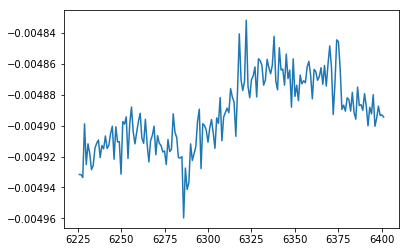

In [132]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

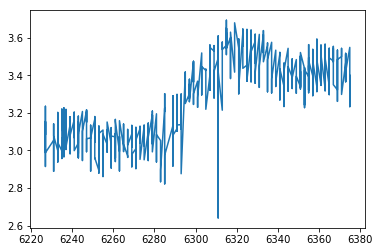

In [133]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

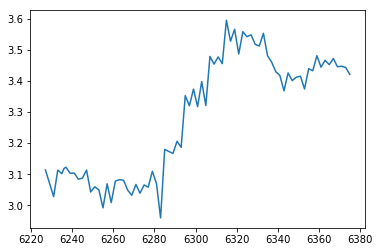

In [134]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

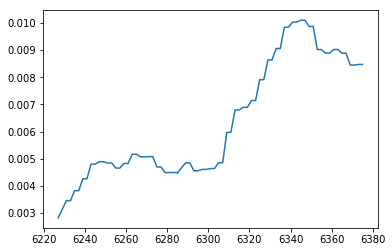

In [135]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [136]:
background_mean = df_mean(background)

# Outlier rejection

In [196]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [197]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [198]:
column = "124/120"
sample = "NIST 200ppb"

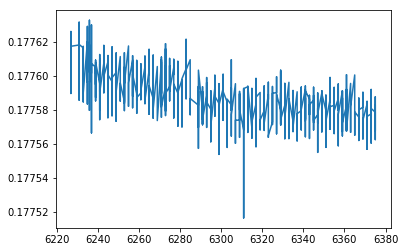

In [199]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [200]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [201]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2017-02-14 20:49:00,NIST 200ppb,2,1,6227,0.029818,0.020194,0.010354,0.445959,0.235327,NaN,0.263514,0.142118,0.177626
2017-02-14 20:49:00,NIST 200ppb,2,2,6227,0.029813,0.020187,0.010358,0.445953,0.235334,0.742935,0.263519,0.142110,0.177624
2017-02-14 20:49:00,NIST 200ppb,2,3,6227,0.029819,0.020188,0.010356,0.445962,0.235333,0.742935,0.263515,0.142112,0.177621
2017-02-14 20:49:00,NIST 200ppb,2,4,6227,0.029815,0.020186,0.010356,0.445954,0.235339,0.742935,0.263514,0.142106,0.177608
2017-02-14 20:49:00,NIST 200ppb,2,5,6227,0.029814,0.020184,0.010356,0.445969,0.235329,0.742935,0.263522,0.142119,0.177617
2017-02-14 20:49:00,NIST 200ppb,2,6,6227,0.029820,0.020188,0.010359,0.445988,0.235341,NaN,0.263519,0.142114,0.177623
2017-02-14 20:49:00,NIST 200ppb,2,7,6227,0.029816,0.020187,0.010359,0.445959,0.235328,0.742935,0.263516,0.142109,0.177620
2017-02-14 20:49:00,NIST 200ppb,2,8,6227,0.029811,0.020185,0.010357,0.445975,0.235343,0.742935,0.263520,0.142112,0.177609
2017-02-14 20:49:00,NIST 200ppb,2,9,6227,0.029811,0.020183,0.010358,0.445959,0.235338,0.742935,0.263514,0.142114,0.177609


In [202]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
6227        2017-02-14 20:49:00    0.187053
6232        2017-02-14 21:55:00    0.186953
            2017-02-14 21:55:00    0.186970
6233        2017-02-14 22:10:00    0.187030
6239        2017-02-14 23:30:00    0.187116
6240        2017-02-14 23:45:00    0.187074
6243        2017-02-15 00:25:00    0.187088
6244        2017-02-15 00:39:00    0.187072
6269        2017-02-15 06:23:00    0.187100
6276        2017-02-15 07:58:00    0.168156
            2017-02-15 07:58:00    0.165635
6289        2017-02-15 12:17:00    0.186910
            2017-02-15 12:17:00    0.186896
6290        2017-02-15 12:31:00    0.186978
            2017-02-15 12:31:00    0.187010
6293        2017-02-15 13:11:00    0.187011
            2017-02-15 13:11:00    0.186973
            2017-02-15 13:11:00    0.187012
            2017-02-15 13:11:00    0.186947
6298        2017-02-15 14:20:00    0.187221
6311        2017-02-15 17:31:00    0.186762
6315        2017-02-15 18:25:00    0.186833


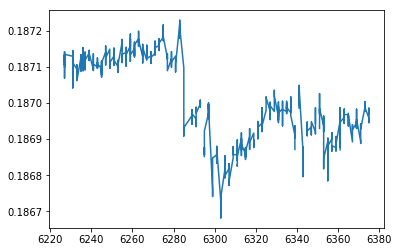

In [203]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [204]:
df[df["Sample"] == sample][column].std()

0.0001164336428012307

In [205]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

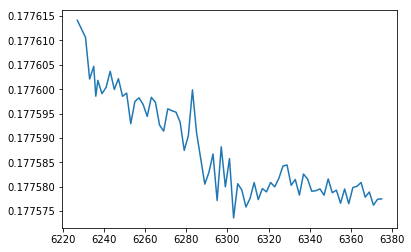

In [206]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [207]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2017-02-14 20:49:00,6227,NIST 200ppb,0.029815,0.020187,0.010358,0.445970,0.235336,0.742935,0.263517,0.142111,0.177614
2017-02-14 21:14:00,6229,NIST 350ppb,0.029813,0.020184,0.010358,0.445962,0.235333,0.742935,0.263517,0.142115,0.177620
2017-02-14 21:40:00,6231,NIST 200ppb,0.029815,0.020185,0.010360,0.445974,0.235336,0.742935,0.263515,0.142111,0.177611
2017-02-14 21:55:00,6232,NIST 350ppb,0.029814,0.020185,0.010359,0.445969,0.235336,0.742935,0.263512,0.142112,0.177613
2017-02-14 22:10:00,6233,NIST 200ppb,0.029819,0.020188,0.010361,0.445985,0.235340,0.742935,0.263512,0.142108,0.177602
2017-02-14 22:35:00,6235,NIST 200ppb,0.029817,0.020188,0.010360,0.445983,0.235338,0.742935,0.263512,0.142108,0.177605
2017-02-14 22:50:00,6236,NIST 200ppb,0.029822,0.020189,0.010360,0.445997,0.235343,0.742935,0.263511,0.142105,0.177599
2017-02-14 23:05:00,6237,NIST 200ppb,0.029821,0.020188,0.010361,0.445990,0.235340,0.742935,0.263506,0.142105,0.177602
2017-02-14 23:30:00,6239,NIST 200ppb,0.029822,0.020191,0.010360,0.445996,0.235342,0.742935,0.263509,0.142103,0.177599


In [208]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [209]:
drop_sum = [pd.Timestamp("2017-02-15 11:26")]

In [210]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [211]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [212]:
data_mean_int_sum

112/120                       114/120  \
                               mean           SD2 count      mean   
Sample                                                              
GRA06100 bomb 1_1          0.029814           NaN     1  0.020188   
Indarch bomb 1_2           0.029812           NaN     1  0.020187   
Indarch bomb 1_2 II        0.029819           NaN     1  0.020189   
Murchison bomb 1_1         0.029812           NaN     1  0.020188   
NIST 200ppb                0.029821  4.854342e-06    73  0.020190   
NIST 200ppb + 0.005ppb U   0.029822  3.556649e-06     2  0.020189   
NIST 200ppb + 0.015ppb U   0.029822           NaN     1  0.020190   
NIST 200ppb + 0.030ppb Cd  0.029823  1.492840e-06     2  0.020192   
NIST 200ppb + 0.04ppb Cd   0.029823  4.841958e-07     2  0.020194   
NIST 200ppb + 0.100ppb Zr  0.029823  3.816750e-06     2  0.020191   
NIST 200ppb + 0.150ppb Rh  0.029821  5.830143e-06     2  0.020190   
NIST 200ppb + 0.300ppb Ru  0.029821  2.754308e-06     2  0.020190   
NIST 200ppb + 0.50ppb Pd   0.029822  1.094892e-07     2  0.020191   
NIST 200ppb + 0.628ppb Te  0.038608  2.484774e-02     2  0.028316   
NIST 200ppb + 2ppb Mo      0.029824  3.649463e-06     2  0.020190   
NIST 200ppb + ME           0.029824  1.655367e-06     2  0.020194   
NIST 25ppb                 0.029819  1.802794e-05     9  0.020187   
NIST 3.5ppb                0.029769  9.913081e-05     9  0.020169   
NIST 350ppb                0.029820  9.072718e-06     9  0.020189   
ZH09-05 23.3_1_7           0.029818           NaN     1  0.020186   
ZH09-05 23.3_3b_2          0.029820           NaN     1  0.020190   

                                                115/120                      \
                                    SD2 count      mean           SD2 count   
Sample                                                                        
GRA06100 bomb 1_1                   NaN     1  0.010359           NaN     1   
Indarch bomb 1_2                    NaN     1  0.010360           NaN     1   
Indarch bomb 1_2 II                 NaN     1  0.010360           NaN     1   
Murchison bomb 1_1                  NaN     1  0.010359           NaN     1   
NIST 200ppb                3.683912e-06    73  0.010361  1.857631e-06    73   
NIST 200ppb + 0.005ppb U   2.759983e-06     2  0.010361  3.229352e-06     2   
NIST 200ppb + 0.015ppb U            NaN     1  0.010362           NaN     1   
NIST 200ppb + 0.030ppb Cd  1.697693e-06     2  0.010360  4.584845e-06     2   
NIST 200ppb + 0.04ppb Cd   1.651618e-06     2  0.010362  8.926873e-08     2   
NIST 200ppb + 0.100ppb Zr  4.608785e-06     2  0.010362  1.832696e-06     2   
NIST 200ppb + 0.150ppb Rh  5.477014e-06     2  0.010361  1.382350e-06     2   
NIST 200ppb + 0.300ppb Ru  1.225018e-06     2  0.010361  1.322309e-06     2   
NIST 200ppb + 0.50ppb Pd   8.927128e-07     2  0.010361  2.206651e-06     2   
NIST 200ppb + 0.628ppb Te  2.298062e-02     2  0.010771  1.152856e-03     2   
NIST 200ppb + 2ppb Mo      1.570530e-06     2  0.010361  8.815108e-07     2   
NIST 200ppb + ME           4.280090e-06     2  0.010362  5.564793e-08     2   
NIST 25ppb                 2.597119e-05     9  0.010355  1.100235e-05     9   
NIST 3.5ppb                1.639244e-04     9  0.010356  5.048100e-05     9   
NIST 350ppb                6.549298e-06     9  0.010361  3.281929e-06     9   
ZH09-05 23.3_1_7                    NaN     1  0.010361           NaN     1   
ZH09-05 23.3_3b_2                   NaN     1  0.010360           NaN     1   

                            116/120  ...  118/120   119/120                  \
                               mean  ...    count      mean       SD2 count   
Sample                               ...                                      
GRA06100 bomb 1_1          0.445987  ...        1  0.263496       NaN     1   
Indarch bomb 1_2           0.445994  ...        1  0.263497       NaN     1   
Indarch bomb 1_2 II        0.446000  ...        1  0.263495       NaN     1   


In [213]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)
epsilon_int_3 = SSB(data_mean_int.drop(date_list), "NIST 3.5ppb", 10000)
delta_raw_3 = SSB(data_mean_raw.drop(date_list), "NIST 3.5ppb", 1000)
epsilon_int_25 = SSB(data_mean_int.drop(date_list), "NIST 25ppb", 10000)
delta_raw_25 = SSB(data_mean_raw.drop(date_list), "NIST 25ppb", 1000)

In [214]:
epsilon_int_3

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-02-16 13:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 3.5ppb
2017-02-16 13:25:00,0.000000,25.370879,50.398875,9.051483,1.144216,0.761393,0.000000e+00,1.653715,-0.885724,-1.944993,NIST 3.5ppb
2017-02-16 13:42:00,-0.782167,-2.049385,11.606154,6.821759,0.324387,-0.850979,-1.110223e-12,-0.744926,1.642495,0.081624,NIST 3.5ppb
2017-02-16 14:11:00,0.782044,-14.953503,-29.685802,-46.668098,-0.307684,-0.403477,-1.110223e-12,-0.084542,-2.656457,0.689624,NIST 3.5ppb
2017-02-16 14:28:00,0.000000,6.064304,1.056135,68.949678,-0.760606,0.801469,2.220446e-12,-0.935370,0.093232,-1.279632,NIST 3.5ppb
2017-02-16 14:45:00,-0.781677,5.443997,6.547386,-57.077013,0.276545,0.123728,-1.110223e-12,-0.612145,4.271286,1.992358,NIST 3.5ppb
2017-02-16 15:14:00,0.781555,9.856822,19.530809,36.118295,0.303596,0.516174,2.220446e-12,1.589821,-2.523401,-1.096107,NIST 3.5ppb
2017-02-16 15:31:00,0.000000,-24.954674,-36.150371,-6.525416,-0.190075,-1.588759,-1.110223e-12,0.278118,0.644660,1.436527,NIST 3.5ppb
2017-02-16 15:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 3.5ppb


In [215]:

date_list_200 = [pd.Timestamp("2017-02-15 09:32:00"), 
                 pd.Timestamp("2017-02-15 11:26:00"), 
                 pd.Timestamp("2017-02-15 12:17:00")]

epsilon_int_200 = epsilon_int_200.drop(date_list_200)
delta_raw_200 = delta_raw_200.drop(date_list_200)
epsilon_int_3 = epsilon_int_3
delta_raw_3 = delta_raw_3
epsilon_int_25 = epsilon_int_25
delta_raw_25 = delta_raw_25

In [216]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -2) & (df["Filenumber"] <= 2)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [217]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)
epsilon_int_3 = epsilon_process(epsilon_int_3)
delta_raw_3 = epsilon_process(delta_raw_3)
epsilon_int_25 = epsilon_process(epsilon_int_25)
delta_raw_25 = epsilon_process(delta_raw_25)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [218]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-02-14 21:14:00,6229,-0.695611,-0.821042,-0.846770,-0.233335,-0.146576,0.000000e+00,0.029442,0.260648,0.416168,NIST 350ppb
2017-02-14 21:40:00,6231,-0.806526,-1.058581,0.772543,-0.068613,-0.068524,0.000000e+00,0.044679,0.102682,0.140669,NIST 200ppb
2017-02-14 21:55:00,6232,-0.706676,-0.630086,-1.538922,-0.230043,-0.094486,0.000000e+00,-0.082881,0.166064,0.402316,NIST 350ppb
2017-02-14 22:10:00,6233,0.889077,0.795017,0.560063,0.140989,0.094992,0.000000e+00,-0.066201,-0.102880,-0.312910,NIST 200ppb
2017-02-14 22:35:00,6235,-0.966143,-0.418415,-0.474436,-0.173931,-0.133595,2.220446e-12,0.013115,0.120873,0.244891,NIST 200ppb
2017-02-14 22:50:00,6236,1.009239,0.506067,0.052649,0.227117,0.184019,2.220446e-12,0.083850,-0.120913,-0.262984,NIST 200ppb
2017-02-14 23:05:00,6237,-0.459851,-0.682982,0.327319,-0.142854,-0.128207,0.000000e+00,-0.152432,0.065942,0.167774,NIST 200ppb
2017-02-14 23:30:00,6239,0.182478,0.508688,-0.298396,0.041653,0.019498,-1.110223e-12,0.066441,-0.101136,-0.112871,NIST 200ppb
2017-02-14 23:45:00,6240,0.198515,-0.431949,0.373293,0.000187,0.002395,0.000000e+00,-0.006990,-0.042662,-0.096127,NIST 200ppb + 2ppb Mo


In [219]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_3_sum = np.round(epsilon_int_3.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_3_sum = np.round(delta_raw_3.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_25_sum = np.round(epsilon_int_25.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_25_sum = np.round(delta_raw_25.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum.append([epsilon_int_3_sum, epsilon_int_25_sum])
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum.append([delta_raw_3_sum, delta_raw_25_sum])
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [220]:
epsilon_sum_all

112/120                   114/120             \
                               mean       SD2 count      mean        SD2   
Sample                                                                     
GRA06100 bomb 1_1            -2.375       NaN     1    -1.644        NaN   
Indarch bomb 1_2             -1.074       NaN     1    -0.230        NaN   
Indarch bomb 1_2 II          -1.173       NaN     1    -1.299        NaN   
Murchison bomb 1_1           -1.098       NaN     1     0.054        NaN   
NIST 200ppb                  -0.004     1.181    69    -0.005      1.597   
NIST 200ppb + 0.005ppb U      0.141     0.562     2    -0.089      0.722   
NIST 200ppb + 0.015ppb U      0.336       NaN     1    -0.808        NaN   
NIST 200ppb + 0.030ppb Cd     0.306     1.292     2     1.368      1.004   
NIST 200ppb + 0.04ppb Cd      0.346     0.236     2     1.435      0.467   
NIST 200ppb + 0.100ppb Zr     0.320     0.221     2     0.142      0.056   
NIST 200ppb + 0.150ppb Rh     0.069     0.772     2     0.301      0.494   
NIST 200ppb + 0.300ppb Ru    -0.104     0.749     2     0.131      2.368   
NIST 200ppb + 0.50ppb Pd     -0.312     0.778     2     0.125      0.744   
NIST 200ppb + 0.628ppb Te  2946.290  8332.960     2  4024.673  11383.588   
NIST 200ppb + 2ppb Mo         0.386     0.529     2     0.021      1.281   
NIST 200ppb + ME              0.624     0.892     2     1.345      0.829   
NIST 350ppb                   0.048     0.992     9     0.299      1.325   
ZH09-05 23.3_1_7             -0.600       NaN     1    -0.896        NaN   
ZH09-05 23.3_3b_2            -0.273       NaN     1    -0.055        NaN   
NIST 3.5ppb                   0.683    33.212     7     3.329     58.939   
NIST 25ppb                   -0.089     9.376     7    -0.113     15.991   

                                 115/120                  116/120  ...   \
                          count     mean       SD2 count     mean  ...    
Sample                                                             ...    
GRA06100 bomb 1_1             1   -2.032       NaN     1   -0.313  ...    
Indarch bomb 1_2              1   -0.617       NaN     1   -0.006  ...    
Indarch bomb 1_2 II           1   -1.683       NaN     1   -0.129  ...    
Murchison bomb 1_1            1   -2.072       NaN     1   -0.006  ...    
NIST 200ppb                  69    0.007     1.115    69    0.004  ...    
NIST 200ppb + 0.005ppb U      2   -0.054     0.115     2   -0.128  ...    
NIST 200ppb + 0.015ppb U      1   -0.544       NaN     1    0.036  ...    
NIST 200ppb + 0.030ppb Cd     2   -0.673     1.106     2   -0.077  ...    
NIST 200ppb + 0.04ppb Cd      2    0.600     0.845     2    0.057  ...    
NIST 200ppb + 0.100ppb Zr     2    0.517     0.900     2    0.148  ...    
NIST 200ppb + 0.150ppb Rh     2    0.097     0.782     2   -0.042  ...    
NIST 200ppb + 0.300ppb Ru     2    0.269     0.196     2   -0.010  ...    
NIST 200ppb + 0.50ppb Pd      2    0.550     0.834     2    0.026  ...    
NIST 200ppb + 0.628ppb Te     2  394.958  1114.509     2  423.541  ...    
NIST 200ppb + 2ppb Mo         2   -0.043     1.178     2    0.011  ...    
NIST 200ppb + ME              2    1.000     1.444     2    0.103  ...    
NIST 350ppb                   9   -0.143     1.612     9    0.112  ...    
ZH09-05 23.3_1_7              1   -0.954       NaN     1   -0.066  ...    
ZH09-05 23.3_3b_2             1   -0.902       NaN     1   -0.218  ...    
NIST 3.5ppb                   7    1.524    88.125     7    0.113  ...    
NIST 25ppb                    7   -0.496     7.606     7    0.002  ...    

                          118/120  119/120                 122/120            \
                            count     mean      SD2 count     mean       SD2   
Sample                                                                         
GRA06100 bomb 1_1               1   -0.077      NaN     1   -0.216       NaN   
Indarch bomb 1_2                1   -0.077      NaN     1    0.030       NaN   
In

In [196]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200.append([epsilon_int_3, epsilon_int_25], min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200.append([delta_raw_3, delta_raw_25], min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

SyntaxError: invalid syntax (<ipython-input-196-46d5f69f4564>, line 6)

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [162]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [163]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [221]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [222]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.append([epsilon_int_3, epsilon_int_25]).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.append([delta_raw_3, delta_raw_25]).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [223]:
writer_orig.save()

In [ ]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

In [224]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')